<a href="https://colab.research.google.com/github/ricardoV94/stats/blob/master/modelling/Socks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beyond tiny data

[Rasmus Bååth](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman/) discusses the following inference problem (paraphrased):

> After drawing 11 socks in a row, and noticing that none are matching pairs, what reasonable estimates can I make for the total number of socks in my house?

He shows how probabilistic problems with *tiny data* like this can be solved by Approximate Bayesian Computation (ABC). The idea is to have the computer simulate repeated datasets with different parameters and to use the proportion of datasets that match the real data as a way to approximate the likelihood function of the data, without having to specify it by hand.

If one repeats this procedure many times while varying the values for the parameters (with the probability of choosing these parameters itself governed by informed prior distributions), they end up with a "reasonable" posterior approximation for the parameters given the observed data.

The pseudo-algorithm goes something like this:
1. Pick a value for each of the model parameters according to a prior distribution
2. Use these parameter values to simulate one observation
3. Compare the simulated observation with the real one. If they match, store the parameter values from step 1, otherwise discard them
4. Repeat steps 1-3 many times
5. Plot the histogram of the saved parameters

With enough draws, the proportion of saved parameters will reflect the 'true' posterior distribution of the model, conditioned on the observed data. Rasmus's [article](http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman/) describes this idea in great detail.

In this post I will attempt to solve the same problem using another Bayesian approximation method: grid sampling. Instead of simulating datasets, I will calculate directly the probability of the observed dataset for any set of parameters. This means I have to write down the likelihood, which means... combinatorics! 

This is how the algorithm will look like:
1. Pick a value for the model parameters and note its prior probability
2. Calculate the likelihood of the observed dataset given these parameter values
3. Multiply the likelihood by the prior probability to get an unnormalized posterior probability and store it
4. Repeat steps 1-3, for as many parameter values as desired.
5. Normalize the posterior probabilities saved in step 3
6. Plot the PMF of the posterior parameters given by step 5

The important change here is that step 3 in the original algorithm is avoided (i.e., discarding information when the simulated and observed data do not match). This is critical to move beyond tiny data. With increasing data, the conclusion of step 3 increasingly becomes NO, meaning that one always discards the result of the simulations. Most of the computational effort will be wasted to learn little more than the fact that the observed data was very unlikely given all the possible outcomes (e.g., If you pick 90 socks from a population of 500, the chance of getting any specific number of pairs is incredible small).

As I mentioned though, the downside of this approach is that one has to find the right formula for the likelihood function that is used in step 2. This was the reason that motivated Rasmus to use ABC in the first place. So, how does this formula look like?

## Combinatorics of a simple world

In a perfect world where there are no socks with missing pairs, there is only one parameter to infer: the total number of M pairs. The probability of observing K pairs, given N draws is given by the following formula:

$$P(K=k | M=m, N=n) = \frac{\binom{m}{k} \binom{m - k}{n - 2k} 2^{n-2k}}{\binom{2m}{k}} $$

Stackexchange user [nispio](https://math.stackexchange.com/users/65676/nispio) provides the formula and an intuitive explanation for it:

> There are $\binom{2m}{n}$ ways to choose $n$ **socks**. Assume first that we have $k=0$, then there are $\binom{m}{n}$ ways to choose from unique pairs, and $2^n$ ways to choose whether we take the left or right **sock** from each pair.

>In the case $k>0$ there are $\binom{m}{k}$ ways to choose which pairs the matches come from and $\binom{m−k}{n−2k}$ ways to choose which pairs the remaining non-matching pairs come from. Of the $n−2k$ non-matching pairs we selected, there are $2^{n−2k}$ ways to choose whether we take the left or right **sock** from each pair.

If you are not familiar with the terminology, $\binom{n}{k}$, it is a shorthand for the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), which gives the number of ways in which one can pick a subset of $k$ elements from a population of $n$ distinct elements, ignoring different orderings. It is also sometimes referred to as "$n$ choose $k$".

The formula above is actually a simple modification of the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution), which gives the probability of observing $k$ elements in a fixed number of $n$ draws from a finite population of $N$ items (without replacement). The modification is needed to account for the fact that we are working with pairs of things. We can either observe a *whole* pair or *one of its two* elements.

Let's see how grid sampling behaves with this simplified model:

In [ ]:
from collections import defaultdict
from functools import lru_cache

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import nbinom, beta
from scipy.special import binom, comb

In [ ]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight='bold') 
plt.rc('axes', labelsize=MEDIUM_SIZE)   
plt.rc('xtick', labelsize=SMALL_SIZE)   
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE) 

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

In [ ]:
def median(values, pmf):
    "Helper function to compute the median of a PMF"
    index = np.where(np.cumsum(pmf) > .5)[0][0]
    return values[index]

In [ ]:
def prob_pairs(m, n, k):
    '''
    Compute the probability of picking k pairs in n draws, given there is a total of m pairs 
    m = number of pairs of socks
    n = number of socks picked
    k = number of pairs observed
    formula described by nispio in https://math.stackexchange.com/a/546519/783483
    '''

    # Impossible events
    if not(m >= k and 2*m >= n and n/2 >= k):
        return 0

    ntotal = binom(2*m, n)
    npairs = binom(m, k)
    nsingles = binom(m - k, n - 2*k) * 2 ** (n - 2*k)
    return npairs * nsingles / ntotal

In [ ]:
# Define prior distribution for our parameter
prior_mu = 30
prior_sd = 15
prior_size = -prior_mu**2 / (prior_mu - prior_sd ** 2)
prior_prob = prior_size / (prior_size + prior_mu)  # Scipy does not allow the prior_mu specification used by Basmus
n_socks = nbinom(prior_size, prior_prob)

# Define grid of parameter values that we want to evaluate
grid = np.arange(0, 101, 2)
prior = np.zeros_like(grid, dtype=np.float)
posterior = np.zeros_like(grid, dtype=np.float)
for i, sock_parameter in enumerate(grid):

    # Compute prior probability and likelihood for each parameter value
    n_pairs = np.floor(sock_parameter / 2)
    prior_probability = n_socks.pmf(sock_parameter)
    likelihood = prob_pairs(n_pairs, n=11, k=0)

    # Store values
    prior[i] = prior_probability
    posterior[i] = prior_probability * likelihood

# Normalize prior and posterior
prior /= np.sum(prior)
posterior /= np.sum(posterior)

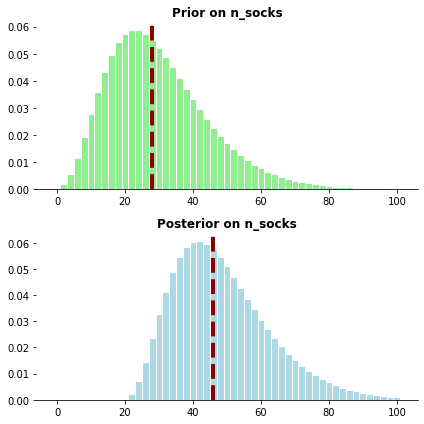

In [ ]:
# Plot results
_, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].bar(grid, prior, width=2, color='#90EE90', ec='w')
ax[0].axvline(median(grid, prior), c='darkred', lw=4, ls='dashed')

ax[1].bar(grid, posterior, width=2, color='#ADD8E6', ec='w')
ax[1].axvline(median(grid, posterior), c='darkred', lw=4, ls='dashed')

ax[0].set_title('Prior on n_socks')
ax[1].set_title('Posterior on n_socks')
plt.tight_layout();

***

## Combinatorics of a messy world

Now let's consider the original case where there can also be L socks that do not have a matching pair, which I will call singletons. The total number of singletons is a new parameter in the model, and it has to be incorporated into the likelihood function.  

After realizing I needed to urgently brush my combinatorics studies, I asked for help online and [joriki](https://math.stackexchange.com/users/6622/joriki) was kind enough to offer the [solution](https://math.stackexchange.com/a/3660412/783483).

The problem is that in most cases, there is no way of knowing whether a non-paired sock comes from the group of $M$ pairs or the group of $L$ singletons. The solution is to iterate over all possible numbers of $L$ singletons that could have been picked. Let's refer to this quantity as $j$, then:

$$P(K=k | M=m, L=l, N=n) = \frac{\binom{m}{k} \sum\limits_{j=0}^{n-2k}\binom{l}{j}\binom{m - k}{n - 2k - j} 2^{n-2k-j}}{\binom{2m + l}{n}} $$

There is now a total of $\binom{2m+l}{n}$ ways of picking n socks. For each possible number of $j$ singletons that we may or may not have picked among all the non-matching socks there are $\binom{l}{j}$ ways of picking those singletons and, similarly to before, $\binom{m - k}{n - 2k - j}$ ways of picking the pairs from which the remaining non-matches come and $2^{n- 2k - j}$ ways to choose whether to take the left or right sock. 

This formula reflects the fact that we are working with a mixture of two hypergeometric distributions when counting socks without pairs: those coming from the pile of socks with pairs and those coming from the pile of socks without pairs. There is no way of knowing which one it is, so we have to average out over all posible combinations of the two!

This was the scary likelihood formula that could be sidestepped with the ABC method. But now that we have it, we don't need to restrict ourselves to the world of tiny data. We can have as much data as we want (barring underflow limitations and the overhead of having to iterate through all possible values of j)!

But first let's see whether I get the same conclusions that Rasmus got with the original dataset of $k=0$ pairs out of $n=11$ draws: 

In [ ]:
@lru_cache(maxsize=256)
def prob_pairs_messy(m, l, n, k):
    '''
    Compute the probability of picking k pairs in n draws, given there is a total of m pairs and l singletons
    m = number of pairs of shoes
    l = number of shoes without pairs
    n = number of shoes picked
    k = number of pairs observed
    formula described by joriki in https://math.stackexchange.com/a/3660412/783483
    '''
    
    # Impossible events
    if not(m >= k and 2*m + l >= n and n/2 >= k):
        return 0

    ntotal = binom(2 * m + l, n)
    npairs = binom(m, k)
    nsingles = 0
    for j in range(0, min(l+1, n-2*k+1)):  # Iterate over all plausible value of j observed singletons.
        nsingles += binom(l, j) * binom( m - k, n - 2*k - j)* 2**(n - 2*k - j)
    return npairs * nsingles / ntotal

Two small performance notes. 

1. I changed slightly the j loop, which in the original formula goes from $0$ to $n-2k$, to go from $0$ to $min \{n-2k, l\}$. If there are not enough singletons, there is no point spending cpu cycles computing those terms (they will be zero). 

2. Second, because this is an expensive function and later on I will be calling it repeatedly with the same inputs, I added the lru_cache decorator. This is a standard and simple way to benefit from [memoization](https://en.wikipedia.org/wiki/Memoization) with Python.



In [ ]:
# Define prior distribution for our parameters
prior_mu = 30
prior_sd = 15
prior_size = -prior_mu**2 / (prior_mu - prior_sd ** 2)
prior_prob = prior_size / (prior_size + prior_mu)  # Scipy does not allow the prior_mu specification used by Basmus with R
n_socks = nbinom(prior_size, prior_prob)

prop_pairs = beta(15, 2)


# Define grid of parameter values that we want to evaluate
grid = dict(n_socks=np.arange(0, 101, 1),
            prop_pairs=np.linspace(0, 1, 50))
prior = np.zeros((grid['n_socks'].size, 
                       grid['prop_pairs'].size), dtype=np.float)
posterior = np.zeros_like(prior, dtype=np.float)

for i, sock_parameter in enumerate(grid['n_socks']):
    for j, prop_parameter in enumerate(grid['prop_pairs']):

        # Compute prior probability and likelihood for each combination of parameter values
        n_pairs = np.int(sock_parameter // 2 * prop_parameter)
        n_odd = sock_parameter - n_pairs * 2

        prior_probability = n_socks.pmf(sock_parameter) * prop_pairs.pdf(prop_parameter)
        likelihood = prob_pairs_messy(n_pairs, n_odd, n=11, k=0)
       
        # Store values
        prior[i, j] = prior_probability
        posterior[i, j] = prior_probability * likelihood

# Normalize prior and posterior
prior /= np.sum(prior)
posterior /= np.sum(posterior)

In [ ]:
# Generate prior and posterior distribution for n_pairs and n_odd
# These values are completely determined by the probability of n_socks and prop_pairs
gen_prior = dict(n_pairs=defaultdict(float), 
                 n_odd=defaultdict(float))

gen_posterior = dict(n_pairs=defaultdict(float), 
                n_odd=defaultdict(float))

for i, sock_value in enumerate(grid['n_socks']):
    for j, prop_value in enumerate(grid['prop_pairs']):
        n_pairs = np.int(sock_value // 2 * prop_value)
        n_odd = sock_value - n_pairs * 2

        gen_prior['n_pairs'][n_pairs] += prior[i, j]
        gen_prior['n_odd'][n_odd] += prior[i, j]
        gen_posterior['n_pairs'][n_pairs] += posterior[i, j]
        gen_posterior['n_odd'][n_odd] += posterior[i, j]

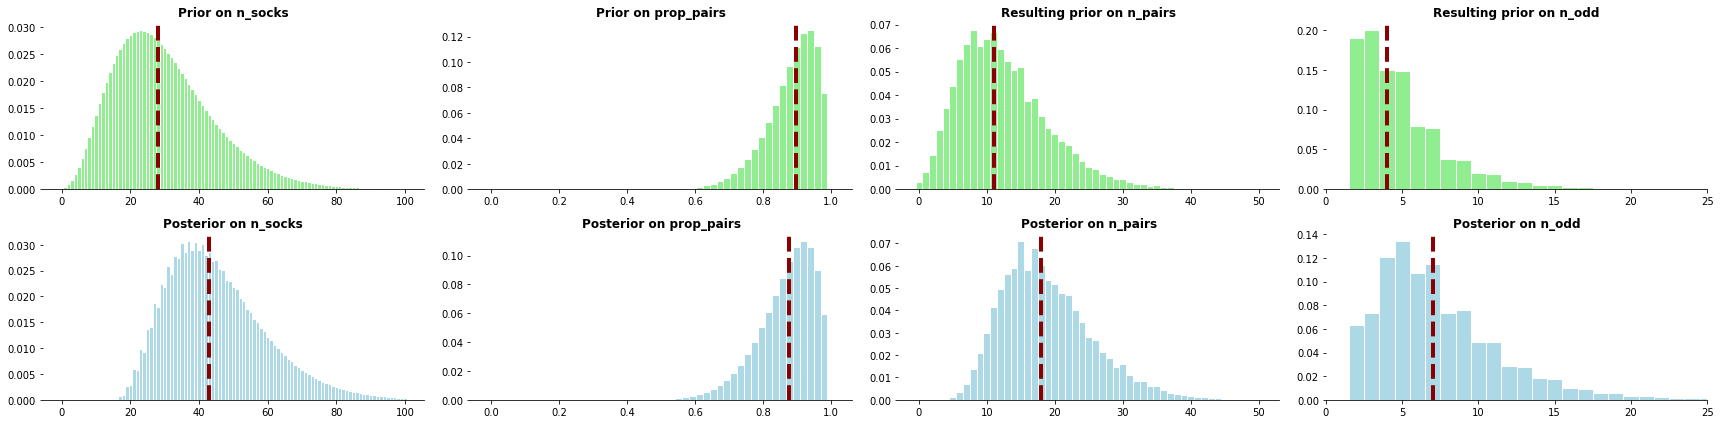

In [ ]:
# Plot results
_, axes = plt.subplots(2, 4, figsize=(24,6))
for i, (ax, var) in enumerate(zip(axes.T, ('n_socks', 'prop_pairs'))):
    ax[0].bar(grid[var], prior.sum(1-i), width=grid[var][1]-grid[var][0], color='#90EE90', ec='w')
    ax[0].axvline(median(grid[var], prior.sum(1-i)), c='darkred', lw=4, ls='dashed')

    ax[1].bar(grid[var], posterior.sum(1-i), width=grid[var][1]-grid[var][0], color='#ADD8E6', ec='w')
    ax[1].axvline(median(grid[var], posterior.sum(1-i)), c='darkred', lw=4, ls='dashed');

for i, (ax, var) in enumerate(zip(axes.T[2:,:], ('n_pairs', 'n_odd'))):
    values = [k for k in gen_prior[var].keys()]
    probs = [v for v in gen_prior[var].values()]
    ax[0].bar(values, probs, width=values[1]-values[0], color='#90EE90', ec='w')
    ax[0].axvline(median(values, probs), c='darkred', lw=4, ls='dashed')

    values = [k for k in gen_posterior[var].keys()]
    probs = [v for v in gen_posterior[var].values()]
    ax[1].bar(values, probs, width=values[1]-values[0], color='#ADD8E6', ec='w')
    ax[1].axvline(median(values, probs), c='darkred', lw=4, ls='dashed')

axes[0, -1].set_xlim([0, 25])
axes[1, -1].set_xlim([0, 25])

axes[0, 0].set_title('Prior on n_socks')
axes[0, 1].set_title('Prior on prop_pairs')
axes[0, 2].set_title('Resulting prior on n_pairs')
axes[0, 3].set_title('Resulting prior on n_odd')
axes[1, 0].set_title('Posterior on n_socks')
axes[1, 1].set_title('Posterior on prop_pairs')
axes[1, 2].set_title('Posterior on n_pairs')
axes[1, 3].set_title('Posterior on n_odd')
plt.tight_layout();

Overall the results seem to match those from Rasmus. Now to the point of this article...

***

## Inference with larger datasets

The original exercise consisted of making probabilistic inferences from a single observation (or experiment). If we wanted to get more accurate inferences, we could collect more independent observations (or perform more experiments) and combine them. 

As I mentioned in the beginning, the Approximate Bayesian Computation technique would begin to fall apart very quickly, because most simulations would result in rejections (they would not exactly match the observed results). Fortunately, we are equipped with the right likelihood function and we can take advantage of larger data with our simple grid algorithm.

In [ ]:
def run_model(data, n=11):
    """
    This function encapsulates the grid algorithm presented before.
    """
    prior_mu = 30
    prior_sd = 15
    prior_size = -prior_mu**2 / (prior_mu - prior_sd ** 2)
    prior_prob = prior_size / (prior_size + prior_mu)
    n_socks = nbinom(prior_size, prior_prob)

    prop_pairs = beta(15, 2)


    grid = dict(n_socks=np.arange(0, 101, 1),
                prop_pairs=np.linspace(0, 1, 50))
    prior = np.zeros((grid['n_socks'].size, 
                        grid['prop_pairs'].size), dtype=np.float)
    posterior = np.zeros_like(prior, dtype=np.float)

    for i, sock_parameter in enumerate(grid['n_socks']):
        for j, prop_parameter in enumerate(grid['prop_pairs']):

            n_pairs = np.int(sock_parameter // 2 * prop_parameter)
            n_odd = sock_parameter - n_pairs * 2

            prior_probability = n_socks.pmf(sock_parameter) * prop_pairs.pdf(prop_parameter)
            likelihood = np.prod([prob_pairs_messy(n_pairs, n_odd, n=n, k=k) for k in data]) # Compute likelihood for all observations
        
            prior[i, j] = prior_probability
            posterior[i, j] = prior_probability * likelihood

    # Normalize prior and posterior
    prior /= np.sum(prior)
    posterior /= np.sum(posterior)

    return grid, prior, posterior

In [ ]:
def plot_results(grid, post, real_m, real_l):
    _, axes = plt.subplots(1, 2, figsize=(12, 3))

    # Plot posterior estimates
    for i, (ax, var) in enumerate(zip(axes.T, ('n_socks', 'prop_pairs'))):
        ax.bar(grid[var], post.sum(1-i), width=grid[var][1]-grid[var][0], color='#ADD8E6', ec='w')
        ax.axvline(median(grid[var], post.sum(1-i)), c='darkred', lw=4, ls='dashed');

    # Plot real values
    axes[0].axvline(real_m*2+real_l, color='green', lw=4, ls='dashed')
    axes[1].axvline(real_m*2/(real_m*2+real_l), color='green', lw=4, ls='dashed')

    axes[0].set_title('Posterior on n_socks')
    axes[1].set_title('Posterior on prop_pairs')
    plt.tight_layout();

In [ ]:
def simulate_data(m, l, n):
    assert n <= m*2 + l

    socks = list(range(m)) * 2 + list(range(-l, 0))
    picked_socks = np.random.choice(socks, n, replace=False)

    obs_pairs = picked_socks.size - np.unique(picked_socks).size
    return obs_pairs

In [ ]:
real_m = 21
real_l = 3
n_draws = 11
data = np.array([simulate_data(real_m, real_l, n_draws) for _ in range(20)])
data

array([1, 1, 2, 3, 1, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 2, 1])

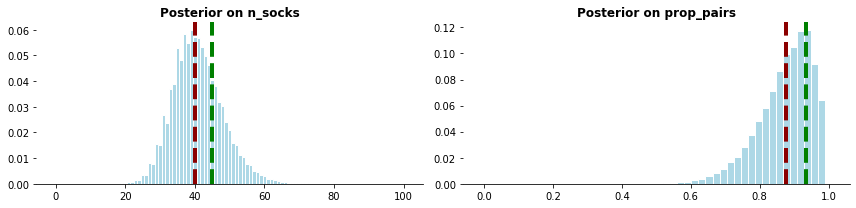

In [ ]:
grid, _, post = run_model(data)
plot_results(grid, post, real_m, real_l)

The plots above show the results of our inference with 20 independent observations. The red lines are the median of the posterior, and the green lines are the true values used to generate the data.

To get a better idea of how the posterior changes as more data is collected, I will plot the results for 1, 5, 25, and 100 datapoints. The first case was the one discussed up until now.

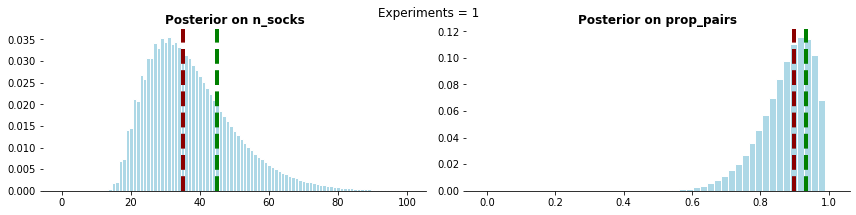

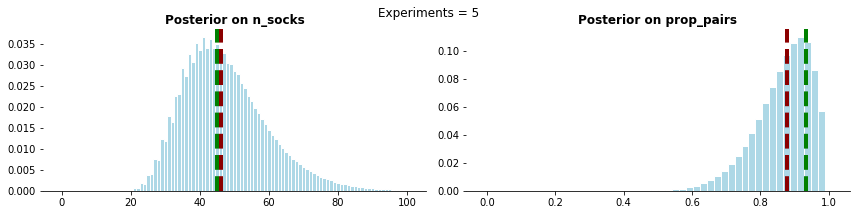

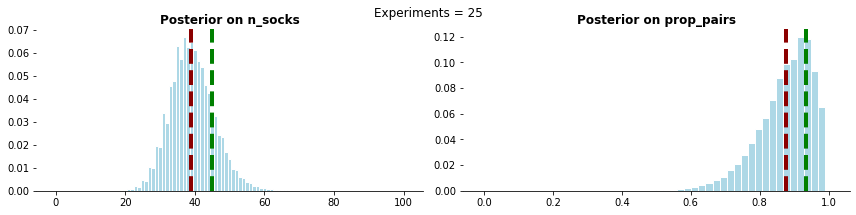

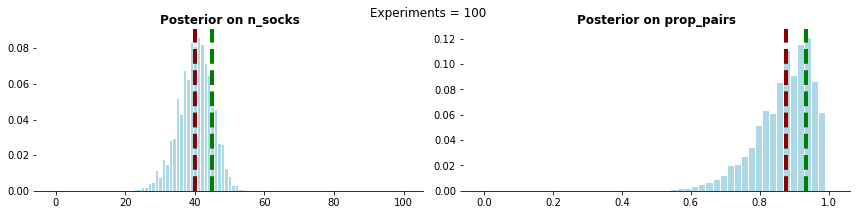

In [ ]:
real_m = 21
real_l = 3
n_draws = 11

for experiments in (1, 5, 25, 100):
    data = np.array([simulate_data(real_m, real_l, n_draws) for _ in range(experiments)])
    grid, _, post = run_model(data, n_draws)
    plot_results(grid, post, real_m, real_l)
    plt.suptitle(f'Experiments = {experiments}')

Two aspects stand out. First, in some simulations we get large differences between the posterior and the true values for $s=1$ or $s=5$ experiments. Second, with $s=100$ experiments, the posterior tends to always be nicely centered around the true value, and to be less spread out (for the number of socks at least), indicating less plausible uncertainty. Obviously, these results will vary from run to run due to sampling noise.

In the next example I doubled the number of draws per experiment, which has a similar effect to running more experiments.

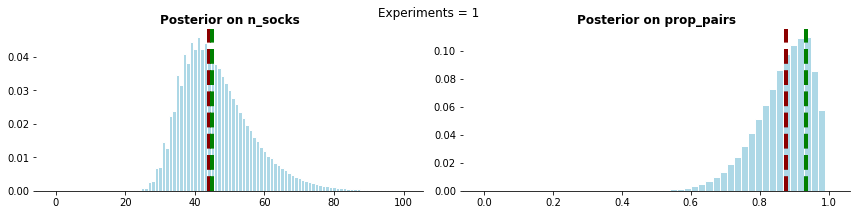

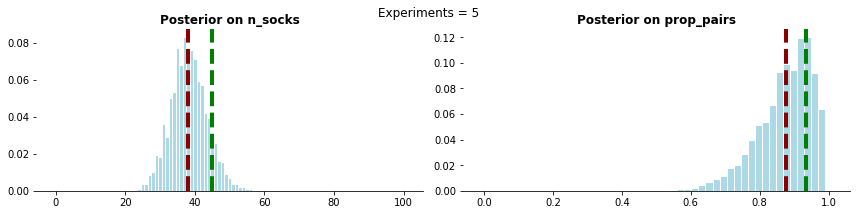

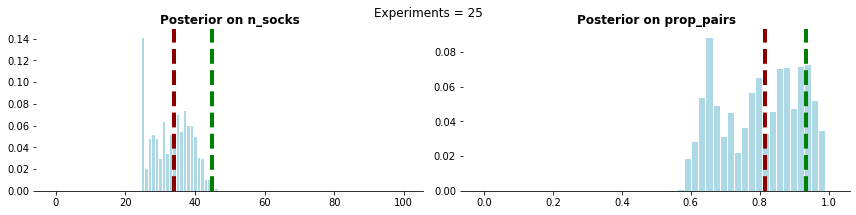

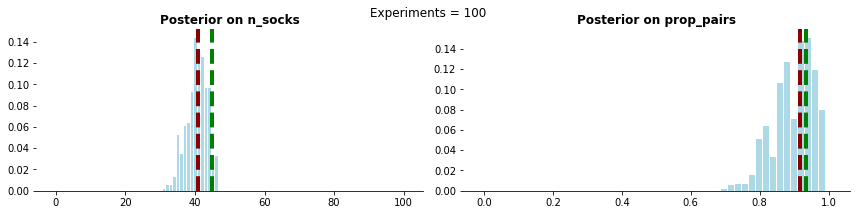

In [ ]:
real_m = 21
real_l = 3
n_draws = 22  # Observing more socks per experiment

for experiments in (1, 5, 25, 100):
    data = np.array([simulate_data(real_m, real_l, n_draws) for _ in range(experiments)])
    grid, _, post = run_model(data, n_draws)
    plot_results(grid, post, real_m, real_l)
    plt.suptitle(f'Experiments = {experiments}')

save_analysis = dict(grid=grid, post=post)

I then decided to check how well the model does if I increase the number of socks.

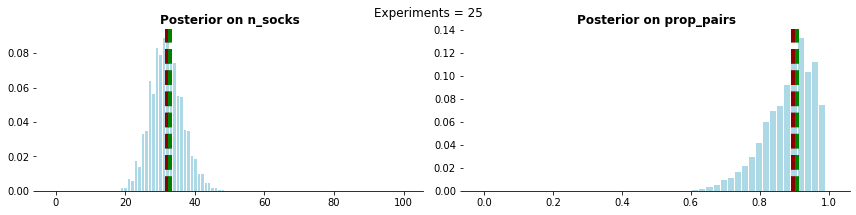

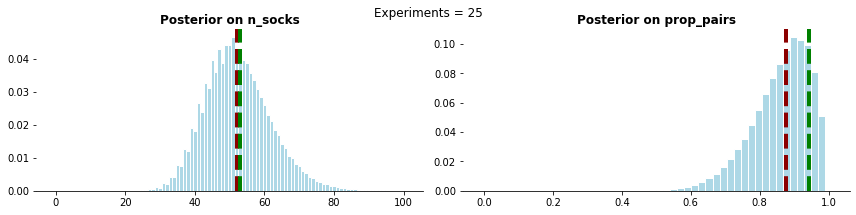

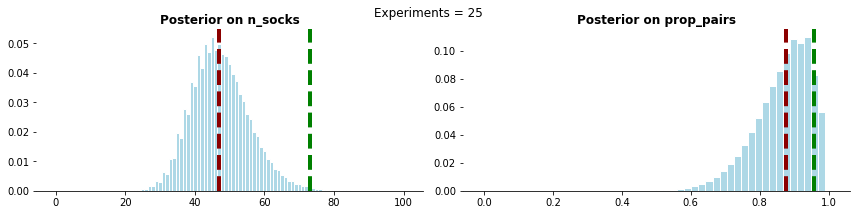

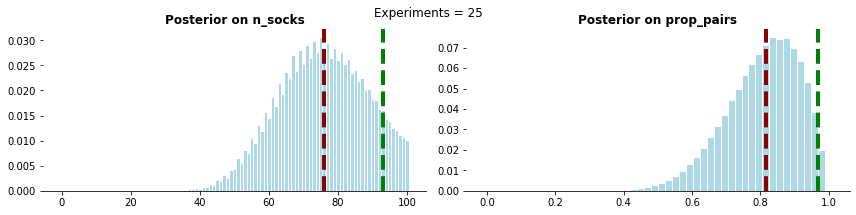

In [ ]:
real_l = 3
n_draws = 11
experiments = 25

for real_m in (15, 25, 35, 45):
    data = np.array([simulate_data(real_m, real_l, n_draws) for _ in range(experiments)])
    grid, _, post = run_model(data, n_draws)
    plot_results(grid, post, real_m, real_l)
    plt.suptitle(f'Experiments = {experiments}')

In general there is some lagging between posterior estimates and the true values, as the prior information weighs considerably in the final inferences. This is an expected consequence of the original strongly informative priors.

The effect of the prior information is also evident when I change the number of singletons and check the estimates for the proportion of pairs.

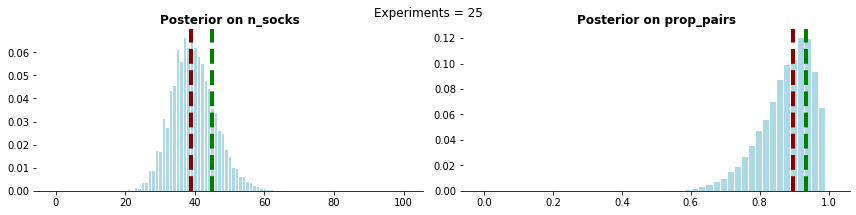

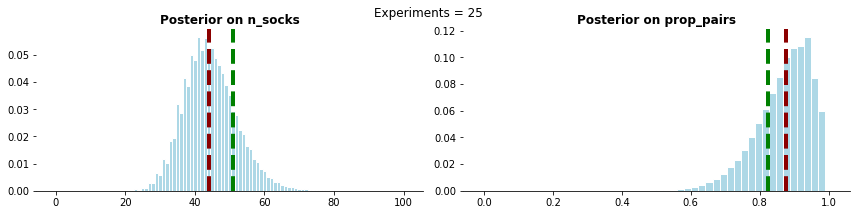

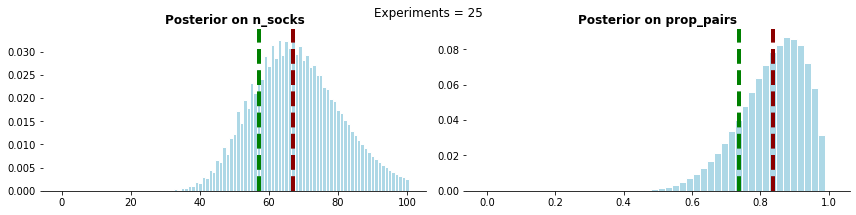

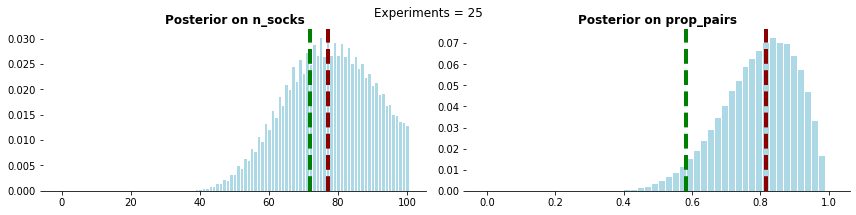

In [ ]:
real_m = 21
n_draws = 11
experiments = 25

for real_l in (3, 9, 15, 30):
    data = np.array([simulate_data(real_m, real_l, n_draws) for _ in range(experiments)])
    grid, prior, post = run_model(data, n_draws)
    plot_results(grid, post, real_m, real_l)
    plt.suptitle(f'Experiments = {experiments}')



It should be noted that the parameters of the grid algorithm (i.e., which parameter values are being evaluated) can drastically influence the conclusions of the model. For instance, in this model the largest value of n_socks that is being considered is 100. If the real number of socks is larger than this, the final conclusions will always be biased, no matter how much data is used. One must pay attention to this when doing grid sampling!

Some of these plots also hint that the model may struggle with finding a jointly plausible posterior for the two parameters. The intuitive reason for this is that we can always explain the absense of observed pairs by either believing in a higher proportion of singletons or in a higher total number of pairs. This can be seen by the moderate degree of covariance in the joint posterior plot of the two parameters in the last analysis:

Text(0.5, 1.0, 'Joint posterior probability')

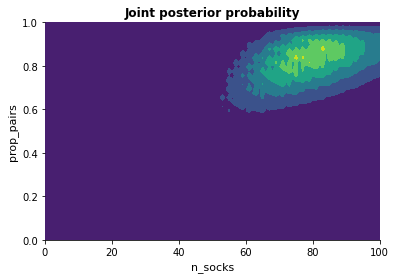

In [ ]:
x, y = np.meshgrid(grid['n_socks'], grid['prop_pairs'])
plt.contourf(x, y, post.T, levels=5)

plt.xlabel('n_socks')
plt.ylabel('prop_pairs')
plt.title('Joint posterior probability')

The degree of posterior covariance was even more extreme in one of the previous analysis with $s=100$ experiments and a large number of draws $n=22$.

Text(0.5, 1.0, 'Joint posterior probability')

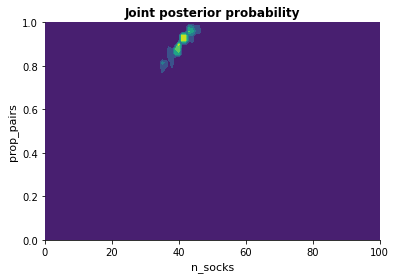

In [ ]:
grid, post = save_analysis['grid'], save_analysis['post']

x, y = np.meshgrid(grid['n_socks'], grid['prop_pairs'])
plt.contourf(x, y, post.T, levels=5)

plt.xlabel('n_socks')
plt.ylabel('prop_pairs')
plt.title('Joint posterior probability')

This issue can only be solved by adding more constraints to the prior, or by adding a separate source of information. For example, if we assume that the probability of a missing pair increases over time, perhaps because items are more likely to get thrown out or lost, we could add information about how old each observed sock is (even a noisy impression might help), which would in turn provide more information to tease apart the two possible explanations for observing a small number of pairs: is there a large number of socks or an unusual number of singletons?

## Beyond tiny models

Like Approximate Bayesian Computation, Grid Sampling is a good tool to understand the logic and mechanics of Bayesian Inference. For those interested in exploring this type of algorithms further, Allen Downey has a fantastic [free book - Think Bayes](https://greenteapress.com/wp/think-bayes/) where he demonstrates how to use grid sampling to tackle a plethora of inference problems in a Bayesian setting.  

One important caveat to the grid sampling algorithm is that it is really only useful for small models that have at most a couple of variables. The size (or volume) of the grid that one has to evaluate grows exponentially with the number of variables in the model. The result of applying grid algorithms to highly dimensional problems is that we end up wasting most of the computational power in regions of the parameter space that have very little probability and that as such contribute little to the posterior distribution. Ironically, if with ABC algorithms and large data we waste most computations to relearn that any specific data is infinitesimally unlikely to have been observed, with grid algorithms and a large number of parameters we waste most of the computation to relearn that most combinations of parameter values are infinitesimally unlikely to have generated any observed data. Large models require smarter algorithms such as [Markov Chain Monte Carlo algorithms](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) that can focus the computational resources on the right comparisons.

## Bonus: Performance benefits from using memoization

In [ ]:
def prob_pairs_messy_uncached(m, l, n, k):
    '''
    m = number of pairs of shoes
    l = number of shoes without pairs
    n = number of shoes picked
    k = number of pairs observed
    formula described by joriki in https://math.stackexchange.com/a/3660412/783483
    '''
    
    # Impossible events
    if not(m >= k and 2*m + l >= n and n/2 >= k):
        return 0

    ntotal = binom(2 * m + l, n)
    npairs = binom(m, k)
    nsingles = 0
    for j in range(0, min(l+1, n-2*k+1)):  # Iterate over all plausible value of j observed singletons.
        nsingles += binom(l, j) * binom( m - k, n - 2*k - j)* 2**(n - 2*k - j)
    return npairs * nsingles / ntotal

In [ ]:
@lru_cache(maxsize=256)
def prob_pairs_messy_cached(m, l, n, k):
    '''
    m = number of pairs of shoes
    l = number of shoes without pairs
    n = number of shoes picked
    k = number of pairs observed
    formula described by joriki in https://math.stackexchange.com/a/3660412/783483
    '''
    
    # Impossible events
    if not(m >= k and 2*m + l >= n and n/2 >= k):
        return 0

    ntotal = binom(2 * m + l, n)
    npairs = binom(m, k)
    nsingles = 0
    for j in range(0, min(l+1, n-2*k+1)):
        nsingles += binom( m - k, n - 2*k - j)* 2**(n - 2*k - j) * binom(l, j)

    return npairs * nsingles / ntotal

In [ ]:
def run_model_perf(data, n=11, cached=True):
    like_func = prob_pairs_messy if cached else prob_pairs_messy_uncached

    prior_mu = 30
    prior_sd = 15
    prior_size = -prior_mu**2 / (prior_mu - prior_sd ** 2)
    prior_prob = prior_size / (prior_size + prior_mu)
    n_socks = nbinom(prior_size, prior_prob)

    prop_pairs = beta(15, 2)


    grid = dict(n_socks=np.arange(0, 101, 1),
                prop_pairs=np.linspace(0, 1, 50))
    prior = np.zeros((grid['n_socks'].size, 
                        grid['prop_pairs'].size), dtype=np.float)
    posterior = np.zeros_like(prior, dtype=np.float)

    for i, sock_value in enumerate(grid['n_socks']):
        for j, prop_value in enumerate(grid['prop_pairs']):

            n_pairs = np.int(sock_value // 2 * prop_value)
            n_odd = sock_value - n_pairs * 2

            prior_probability = n_socks.pmf(sock_value) * prop_pairs.pdf(prop_value)
            likelihood = np.prod([like_func(n_pairs, n_odd, n=n, k=k) for k in data])
        
            prior[i, j] = prior_probability
            posterior[i, j] = prior_probability * likelihood

    prior /= np.sum(prior)
    posterior /= np.sum(posterior)

    return grid, prior, posterior

In [ ]:
data = np.array([simulate_data(21, 3, 11) for _ in range(200)])
data

array([0, 2, 0, 3, 0, 0, 1, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1,
       3, 2, 1, 1, 1, 1, 3, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 1, 3,
       2, 2, 1, 0, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 0, 2,
       3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 3, 0, 1, 1, 1, 0, 3, 2, 2, 1,
       2, 0, 0, 1, 1, 0, 2, 0, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1, 1, 3, 1, 1,
       0, 2, 1, 1, 0, 3, 1, 1, 0, 1, 2, 0, 2, 1, 1, 1, 3, 1, 1, 1, 2, 0,
       0, 2, 1, 1, 0, 0, 2, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 2,
       0, 0, 0, 1, 2, 2, 1, 0, 0, 1, 2, 2, 1, 1, 3, 1, 0, 0, 1, 3, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 2, 3, 0, 1, 0, 0, 1, 2, 1, 1, 1, 2, 2, 1, 1,
       1, 2])

In [ ]:
cached_perf = []
uncached_perf = []
for data_n in (1, 5, 25, 100, 200):
    subdata = data[:data_n]
    res1 = %timeit -o run_model_perf(subdata, cached=True)
    res2 = %timeit -o run_model_perf(subdata, cached=False)

    cached_perf.append(res1.best)
    uncached_perf.append(res2.best)

1 loop, best of 3: 1.85 s per loop
1 loop, best of 3: 2.02 s per loop
1 loop, best of 3: 2.14 s per loop
1 loop, best of 3: 3.38 s per loop
1 loop, best of 3: 2.41 s per loop
1 loop, best of 3: 9.64 s per loop
1 loop, best of 3: 2.63 s per loop
1 loop, best of 3: 33.8 s per loop
1 loop, best of 3: 2.91 s per loop
1 loop, best of 3: 1min 6s per loop


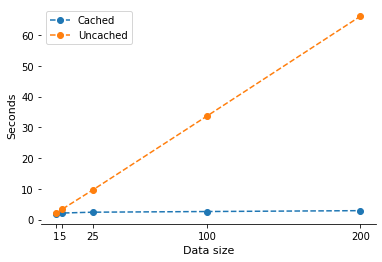

In [ ]:
x = (1, 5, 25, 100, 200)
plt.plot(x, cached_perf, ls='--', marker='o', label='Cached')
plt.plot(x, uncached_perf, ls='--', marker='o', label='Uncached')

plt.xticks(x)
plt.ylabel('Seconds')
plt.xlabel('Data size')
plt.legend()
